In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = generate_training_data(samples=10000, return_df=True)
X = df[['w1', 'w2', 'Cb']].values
y = df['Cb_next'].values

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 273715.31it/s]


#### Modeling

In [4]:
input_dim = X.shape[1]
output_dim = 1

model = NeuralNet(input_dim,output_dim).to(device)
model = train_nn(model, X, y, 20000)

# # Or use a SVR
# model = SVR(C=10).fit(X, y)

Epoch [1000/20000], Loss: 0.0952
Epoch [2000/20000], Loss: 0.0934
Epoch [3000/20000], Loss: 0.0910
Epoch [4000/20000], Loss: 0.0873
Epoch [5000/20000], Loss: 0.0813
Epoch [6000/20000], Loss: 0.0717
Epoch [7000/20000], Loss: 0.0540
Epoch [8000/20000], Loss: 0.0194
Epoch [9000/20000], Loss: 0.0059
Epoch [10000/20000], Loss: 0.0047
Epoch [11000/20000], Loss: 0.0042
Epoch [12000/20000], Loss: 0.0041
Epoch [13000/20000], Loss: 0.0040
Epoch [14000/20000], Loss: 0.0039
Epoch [15000/20000], Loss: 0.0043
Epoch [16000/20000], Loss: 0.0039
Epoch [17000/20000], Loss: 0.0039
Epoch [18000/20000], Loss: 0.0038
Epoch [19000/20000], Loss: 0.0038
Epoch [20000/20000], Loss: 0.0038


#### Optimization

In [5]:
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])

Cb_res, w1_res = simulation(model, Cb_ref, method='PSO')

  2%|▏         | 1/60 [00:01<00:59,  1.01s/it]

Stopping search: Swarm best objective change less than 1e-08


  3%|▎         | 2/60 [00:02<01:31,  1.58s/it]

Stopping search: Swarm best objective change less than 1e-08


  5%|▌         | 3/60 [00:04<01:33,  1.64s/it]

Stopping search: Swarm best objective change less than 1e-08


  7%|▋         | 4/60 [00:06<01:26,  1.54s/it]

Stopping search: Swarm best objective change less than 1e-08


  8%|▊         | 5/60 [00:07<01:13,  1.34s/it]

Stopping search: Swarm best objective change less than 1e-08


 10%|█         | 6/60 [00:07<01:03,  1.17s/it]

Stopping search: Swarm best objective change less than 1e-08


 12%|█▏        | 7/60 [00:08<00:55,  1.06s/it]

Stopping search: Swarm best objective change less than 1e-08


 13%|█▎        | 8/60 [00:09<00:52,  1.00s/it]

Stopping search: Swarm best objective change less than 1e-08


 15%|█▌        | 9/60 [00:10<00:48,  1.05it/s]

Stopping search: Swarm best objective change less than 1e-08


 17%|█▋        | 10/60 [00:11<00:48,  1.02it/s]

Stopping search: Swarm best objective change less than 1e-08


 18%|█▊        | 11/60 [00:12<00:46,  1.05it/s]

Stopping search: Swarm best objective change less than 1e-08


 20%|██        | 12/60 [00:13<00:42,  1.12it/s]

Stopping search: Swarm best objective change less than 1e-08


 22%|██▏       | 13/60 [00:14<00:41,  1.13it/s]

Stopping search: Swarm best objective change less than 1e-08


 23%|██▎       | 14/60 [00:14<00:40,  1.13it/s]

Stopping search: Swarm best objective change less than 1e-08


 25%|██▌       | 15/60 [00:15<00:39,  1.14it/s]

Stopping search: Swarm best objective change less than 1e-08


 27%|██▋       | 16/60 [00:16<00:38,  1.15it/s]

Stopping search: Swarm best objective change less than 1e-08


 28%|██▊       | 17/60 [00:17<00:40,  1.06it/s]

Stopping search: Swarm best objective change less than 1e-08


 30%|███       | 18/60 [00:18<00:40,  1.05it/s]

Stopping search: Swarm best objective change less than 1e-08


 32%|███▏      | 19/60 [00:20<00:43,  1.06s/it]

Stopping search: Swarm best objective change less than 1e-08


 33%|███▎      | 20/60 [00:20<00:37,  1.06it/s]

Stopping search: Swarm best objective change less than 1e-08


 35%|███▌      | 21/60 [00:21<00:36,  1.08it/s]

Stopping search: Swarm best objective change less than 1e-08


 37%|███▋      | 22/60 [00:22<00:34,  1.10it/s]

Stopping search: Swarm best objective change less than 1e-08


 38%|███▊      | 23/60 [00:23<00:33,  1.11it/s]

Stopping search: Swarm best objective change less than 1e-08


 40%|████      | 24/60 [00:24<00:32,  1.12it/s]

Stopping search: Swarm best objective change less than 1e-08


 42%|████▏     | 25/60 [00:25<00:32,  1.08it/s]

Stopping search: Swarm best objective change less than 1e-08


 43%|████▎     | 26/60 [00:25<00:29,  1.14it/s]

Stopping search: Swarm best objective change less than 1e-08


 45%|████▌     | 27/60 [00:26<00:28,  1.15it/s]

Stopping search: Swarm best objective change less than 1e-08


 47%|████▋     | 28/60 [00:28<00:34,  1.08s/it]

Stopping search: Swarm best objective change less than 1e-08


 48%|████▊     | 29/60 [00:29<00:31,  1.01s/it]

Stopping search: Swarm best objective change less than 1e-08


 50%|█████     | 30/60 [00:30<00:28,  1.06it/s]

Stopping search: Swarm best objective change less than 1e-08


 52%|█████▏    | 31/60 [00:30<00:26,  1.09it/s]

Stopping search: Swarm best objective change less than 1e-08


 53%|█████▎    | 32/60 [00:31<00:25,  1.10it/s]

Stopping search: Swarm best objective change less than 1e-08


 55%|█████▌    | 33/60 [00:33<00:30,  1.13s/it]

Stopping search: Swarm best objective change less than 1e-08


 57%|█████▋    | 34/60 [00:34<00:28,  1.10s/it]

Stopping search: Swarm best objective change less than 1e-08


 58%|█████▊    | 35/60 [00:35<00:25,  1.03s/it]

Stopping search: Swarm best objective change less than 1e-08


 60%|██████    | 36/60 [00:36<00:23,  1.02it/s]

Stopping search: Swarm best objective change less than 1e-08


 62%|██████▏   | 37/60 [00:37<00:21,  1.05it/s]

Stopping search: Swarm best objective change less than 1e-08


 63%|██████▎   | 38/60 [00:38<00:20,  1.05it/s]

Stopping search: Swarm best objective change less than 1e-08


 65%|██████▌   | 39/60 [00:39<00:25,  1.20s/it]

Stopping search: Swarm best objective change less than 1e-08


 67%|██████▋   | 40/60 [00:40<00:22,  1.11s/it]

Stopping search: Swarm best objective change less than 1e-08


 68%|██████▊   | 41/60 [00:41<00:19,  1.03s/it]

Stopping search: Swarm best objective change less than 1e-08


 70%|███████   | 42/60 [00:42<00:20,  1.13s/it]

Stopping search: Swarm best objective change less than 1e-08


 72%|███████▏  | 43/60 [00:44<00:20,  1.20s/it]

Stopping search: Swarm best objective change less than 1e-08


 73%|███████▎  | 44/60 [00:44<00:16,  1.05s/it]

Stopping search: Swarm best objective change less than 1e-08


 75%|███████▌  | 45/60 [00:45<00:14,  1.03it/s]

Stopping search: Swarm best objective change less than 1e-08


 77%|███████▋  | 46/60 [00:46<00:13,  1.06it/s]

Stopping search: Swarm best objective change less than 1e-08


 78%|███████▊  | 47/60 [00:47<00:12,  1.08it/s]

Stopping search: Swarm best objective change less than 1e-08


 80%|████████  | 48/60 [00:48<00:10,  1.10it/s]

Stopping search: Swarm best objective change less than 1e-08


 82%|████████▏ | 49/60 [00:49<00:09,  1.12it/s]

Stopping search: Swarm best objective change less than 1e-08


 83%|████████▎ | 50/60 [00:51<00:12,  1.23s/it]

Stopping search: Swarm best objective change less than 1e-08


 85%|████████▌ | 51/60 [00:52<00:10,  1.16s/it]

Stopping search: Swarm best objective change less than 1e-08


 87%|████████▋ | 52/60 [00:52<00:08,  1.00s/it]

Stopping search: Swarm best objective change less than 1e-08


 88%|████████▊ | 53/60 [00:53<00:07,  1.03s/it]

Stopping search: Swarm best objective change less than 1e-08


 90%|█████████ | 54/60 [00:54<00:05,  1.04it/s]

Stopping search: Swarm best objective change less than 1e-08


 92%|█████████▏| 55/60 [00:55<00:04,  1.02it/s]

Stopping search: Swarm best objective change less than 1e-08


 93%|█████████▎| 56/60 [00:56<00:04,  1.00s/it]

Stopping search: Swarm best objective change less than 1e-08


 95%|█████████▌| 57/60 [00:57<00:02,  1.04it/s]

Stopping search: Swarm best objective change less than 1e-08


 97%|█████████▋| 58/60 [00:58<00:01,  1.06it/s]

Stopping search: Swarm best objective change less than 1e-08


 98%|█████████▊| 59/60 [00:59<00:00,  1.13it/s]

Stopping search: Swarm best objective change less than 1e-08


100%|██████████| 60/60 [01:00<00:00,  1.01s/it]

Stopping search: Swarm best objective change less than 1e-08


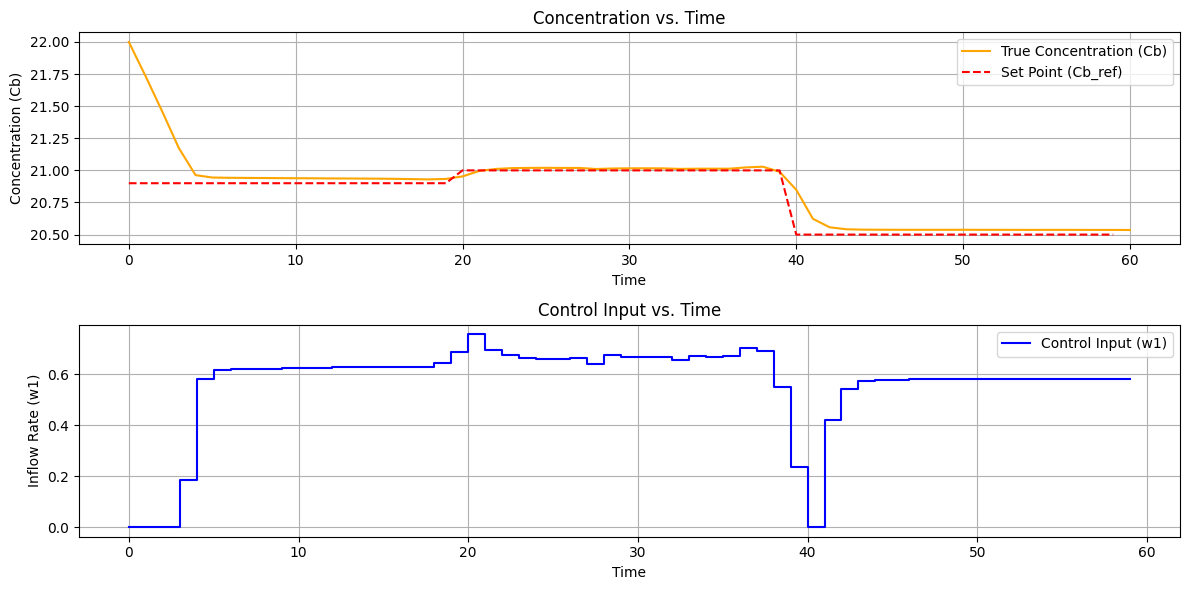

In [12]:
plot_results(Cb_res, Cb_ref, w1_res)

#### Evaluation of optimal `w1` using the real system dynamics

In [13]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# --- Real System Dynamics --- #
def system_of_odes(t, y, w2):
    h, Cb = y
    w1 = w1_func(t)  # Get w1 at time t using interpolation
    dh_dt = w1 + w2 - 0.2 * np.sqrt(h)
    dCb_dt = ((Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2)
    return [dh_dt, dCb_dt]

# Make negative w1_res zero
t_points = np.arange(0, L, dt)  
w1_func = interp1d(t_points, w1_res, kind='linear', fill_value="extrapolate")

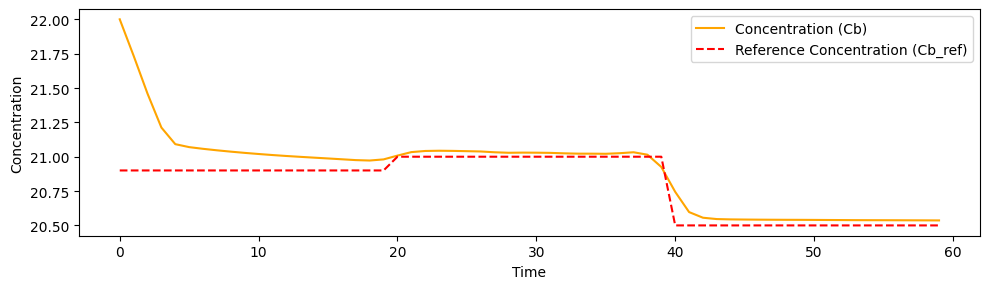

In [14]:
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
times = np.arange(0, L, dt)
sol_t = [0]
sol_h = [h0]
sol_Cb = [Cb0]

for i in range(len(times)-1):
    sol = solve_ivp(system_of_odes, [times[i], times[i+1]], y0, args=(w2,), method='RK45')  
    y0 = sol.y[:, -1]  # Update initial condition
    sol_t.append(times[i+1])
    sol_h.append(y0[0])
    sol_Cb.append(y0[1])
    
sol_t = np.array(sol_t)
sol_h = np.array(sol_h)
sol_Cb = np.array(sol_Cb)

# --- Plotting --- #
plt.figure(figsize=(10, 3))
plt.plot(sol_t, sol_Cb, label='Concentration (Cb)', color='orange')
plt.plot(sol_t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.tight_layout()
plt.show()

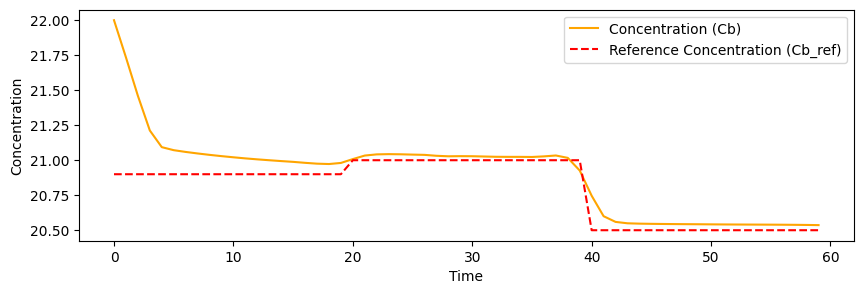

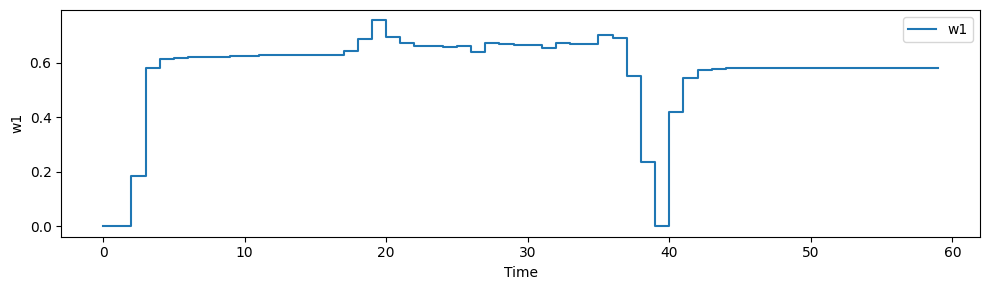

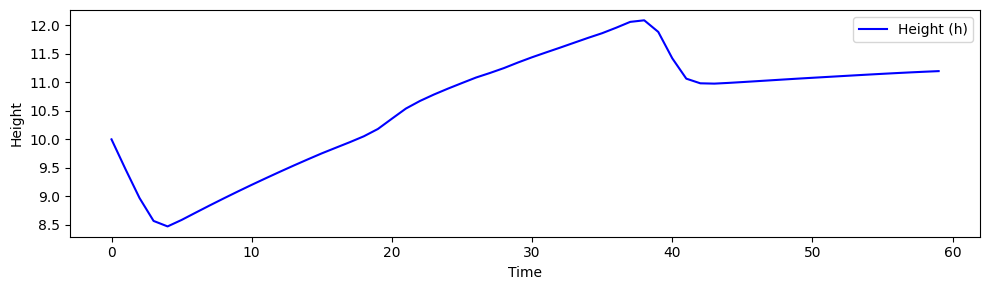

In [15]:
# Time span for the solution
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
sol = solve_ivp(system_of_odes, t_span, y0, args=(w2,), 
                method='Radau', t_eval=np.arange(0, L, dt))

# Extract the solution
t = sol.t
h = sol.y[0]
Cb = sol.y[1]

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Concentration (Cb)', color='orange')
plt.plot(t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

# Plot the input w1
plt.figure(figsize=(10, 3))
plt.step(t, w1_func(t), label='w1')
plt.xlabel('Time')
plt.ylabel('w1')    
plt.legend()

plt.tight_layout()
plt.show()

# Plot h 
plt.figure(figsize=(10, 3))
plt.plot(t, h, label='Height (h)', color='blue')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
results_df = pd.DataFrame()
results_df['MPC'] = Cb_res[:-1]
results_df['Real'] = Cb
results_df['Diff'] = np.abs(results_df['MPC'] - results_df['Real'])
results_df

,MPC,Real,Diff
0,22.000000,22.000000,0.000000e+00
1,21.734571,21.734571,7.262464e-08
2,21.459090,21.459965,8.751827e-04
3,21.172980,21.212415,3.943493e-02
4,20.962960,21.093402,1.304416e-01
5,20.944378,21.071763,1.273845e-01
6,20.942352,21.059226,1.168736e-01
7,20.941344,21.048277,1.069328e-01
8,20.940465,21.038317,9.785221e-02
9,20.939685,21.029230,8.954521e-02


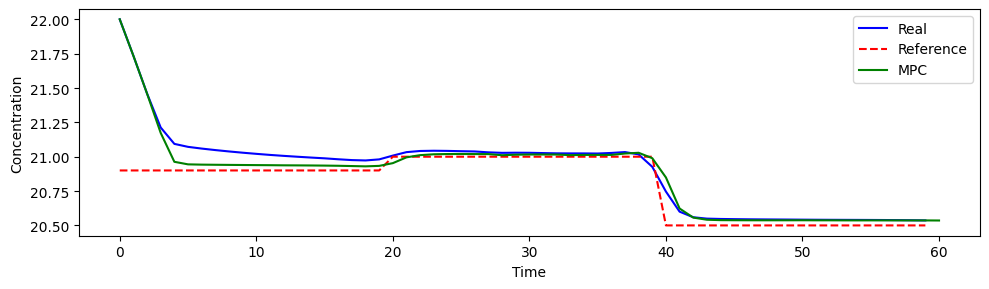

In [17]:
# Plot results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Real', color='blue')
plt.plot(t, Cb_ref, label='Reference', color='red', linestyle='--')
plt.plot(Cb_res, label='MPC', color='green', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.tight_layout()
plt.show()